In [1]:
import os, sys
sys.path.insert(0,'../submodule/m-phate')

In [5]:
import numpy as np
import pandas as pd
import json
import matplotlib
import matplotlib.pyplot as plt
import math, random, pickle
from tqdm import tqdm_notebook as tqdm

import engine

from pyexperimentparser.dataset.dataset import  Dataset
from pyexperimentparser.experiment.experiment import  Experiment
from pyexperimentparser.utils import preprocess
from pyexperimentparser.utils import utils

from importlib import import_module

from absl import app
from absl import logging
from absl import flags

In [6]:
import m_phate
import scprep
from scipy.ndimage import gaussian_filter
from sklearn.cluster import KMeans

In [7]:
def parse(config):
  pars = config['parameters']
  return pars

In [8]:
with open('../config.json', 'r') as json_file:
    config = json.load(json_file)

pars = parse(config)
trial_ind_show = 0
data_dir = pars['data_dir']
# special trial (repetition) to show (Change it if you need)
rois_per_trial_num = pars['rois_per_trial_num']
# frame rate ratio between Two Photon imaging and Behavior
frame_rate_ratio      = pars['frame_rate_ratio']
# Common names to be converted to Ids
event_name_list      = pars['event_name_list']

procs = pars['processors']
verbosity = pars['verbosity']

In [9]:
dates_to_process = pars['dates_to_process'] # e.g. 8_13_17, 8_6_17, 8_7_17 are "expert" days
cell_type = pars['cell_type']  # soma

In [12]:
#expdir = "/Users/orange3xchicken/pyexperimentparser/data/8_10_17_1/"
expdir = "/Users/orange3xchicken/pyexperimentparser/data_pkl/8_6_17/8_6_17_1.pkl"

In [11]:
## if importing from .mat files, need to start a base virtual matlab instance
#import engine
#engine.init()
#exp = Experiment(idx=0,path=expdir,ftype='mat')

In [15]:
# otherwise can load dataset/experiments from pickle
exp = pickle.load(open(expdir, 'rb'))

In [18]:
# older version of the class required sorting trials after instantiation
idx = [tr.idx for tr in exp.trial_list]
exp.trial_list = [x for _,x in sorted(zip(idx,exp.trial_list))]

In [19]:
# Load data arrays

Data_x = [] # calcium content
Data_y = [] # success-failure data
trials_label_per_day_list = [] # behavioral data
trials_per_day_list = []
#for exp in tqdm(ds.experiment_list):
event_name_per_trial = []
data_per_trial = []
success_per_trial = []
for trial in exp.trial_list: 
    if len(trial.bda_list) < 1 or len(trial.tpa_list) < 1:
        continue
    # extract ROI df/F data
    rois_per_trial_num   = len(trial.tpa_list)
    dffData = trial.tpa_list[0].procROI
    framNum = dffData.shape[0]
    dffDataArray = np.tile(dffData, (rois_per_trial_num,1))
    roiNames = []

    for m in range(rois_per_trial_num):
        dffDataArray[m,:] = trial.tpa_list[m].procROI
        roiNames.append(trial.tpa_list[m].Name)

    # extract Event Time data
    eventsPerTrialNum   = len(trial.bda_list)
    timeData         = trial.bda_list[0].TimeInd
    eventDataArray   = np.zeros((framNum,eventsPerTrialNum))
    eventNames       = []

    for m in range(eventsPerTrialNum):
        timeInd     = np.array(trial.bda_list[m].tInd).flatten()
        timeInd     = np.round(timeInd/frame_rate_ratio) # transfers to time of the two photon

        timeInd     = np.concatenate(([1],[np.min(np.concatenate((timeInd, [framNum])))]))
        timeInd = np.sort(timeInd)
        eventDataArray[int(timeInd[0]):int(timeInd[1]),m] = 1
        eventNames.append((trial.bda_list[m].Name, trial.bda_list[m].SeqNum))
        
    event_name_per_trial.append(eventNames)

    if len(eventNames) > 1:
        Data_x.append(dffDataArray.T)
        data_per_trial.append(dffDataArray.T)
        if eventNames[1][0] == 'success':
            success_per_trial.append(1)
        else:
            success_per_trial.append(0)
trials_label_per_day_list.append(event_name_per_trial)
trials_per_day_list.append(data_per_trial)
Data_y.append(success_per_trial)

In [27]:
activitypertrial = [[[activity[0].split(':')[0] for activity in trial] for trial in day] for day in trials_label_per_day_list]

In [28]:
activity2idx = list(set([s for d in activitypertrial for t in d for s in t]))

In [29]:
activityidpertrial = [[activity2idx.index(x) for x in d] for day in activitypertrial for d in day ]

In [30]:
num_grabs_per_day = [[trial.count('Grab') for trial in d]for d in activitypertrial]

In [42]:
idx = 1
X_tr = Data_x_subset = np.stack(trials_per_day_list)
Y_tr = Data_y_subset = np.stack(trials_label_per_day_list)

In [50]:
# tensor of size trials x time x neurons, can also try different timesteps about the tone here
X = np.stack(Data_x_subset)[0][:,50:280,:]

In [51]:
X.shape

(70, 230, 379)

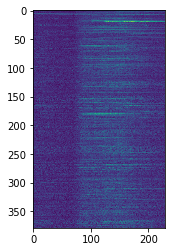

In [52]:
plt.imshow(X[0].T)

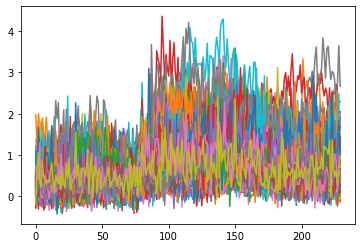

In [57]:
plt.plot(X[0])
plt.show()

In [58]:
n_trials = X.shape[0]
n_neurons = X.shape[2]
n_time = X.shape[1]

In [59]:
# Characterize inter/intra-slice dimensions here
X_tr = X.transpose(0,2,1)
print(X_tr.shape)

(70, 379, 230)


In [33]:
# default params for knn
interslice_knn = 25
intraslice_knn = 2
m_phate_op = m_phate.M_PHATE(normalize=False, n_components=3, n_jobs=-2, intraslice_knn=intra_knn, interslice_knn=inter_knn)
m_phate_data = m_phate_op.fit_transform(X_tr)
scprep.plot.scatter3d(m_phate_data, c=np.repeat(np.arange(n_trials),n_neurons), ticks=False, label_prefix="M-PHATE")

In [ ]:
"""
gridsearch
intra_knns = [1,2,5,10,15,20]
inter_knns = [5,10,15,20,25,35]
time = np.repeat(np.arange(n_trials),n_neurons)
for intra_knn in tqdm(intra_knns):
    for inter_knn in inter_knns:
        fname = 'SOMA-8-7-17-trials-neurons-time-intra_knn=%sinter_knn=%s' % (intra_knn, inter_knn)
        m_phate_op = m_phate.M_PHATE(normalize=False, n_components=3, n_jobs=-2, intraslice_knn=intra_knn, interslice_knn=inter_knn)
        m_phate_data = m_phate_op.fit_transform(X_tr)
        scprep.plot.scatter3d(m_phate_data, c=time, ticks=False, filename=fname+'.png', title=fname, label_prefix="M-PHATE")
"""

In [211]:
success_ids = np.tile(Data_y_subset, n_trials)

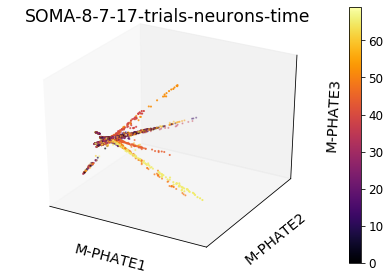

In [213]:
# plot
#n_time_steps, n_points, n_dim
#activity = np.repeat(Data_y[idx], n_neurons)
#num_grabs = np.repeat(num_grabs_per_day[idx], n_neurons)
#success_failure = success_ids
trials = np.repeat(np.arange(n_trials),n_neurons)
scprep.plot.scatter3d(m_phate_data, c=trials, ticks=False, title='SOMA-8-7-17-trials-neurons-time', label_prefix="M-PHATE",filename=None)

In [181]:
scprep.plot.rotate_scatter3d(m_phate_data, c=time, ticks=False, title='SOMA-8-7-17-trials-neurons-time', label_prefix="M-PHATE",filename=None)